In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Evaluation metrics used for th etypical supervised ML tasks
def evaluation_metric(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [4]:
# Data wrangling and visualization
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

In [5]:
# ARIMA Model
# Data Frame associated
df = pd.read_csv("/content/drive/MyDrive/ds_totalsales.csv")
df.head()

,Month,Total_Sales_Adjusted
0,1/1/1992,2073.432724
1,2/1/1992,2114.485812
2,3/1/1992,2260.570891
3,4/1/1992,2255.103236
4,5/1/1992,2331.414618


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Month                 338 non-null    object 
 1   Total_Sales_Adjusted  338 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.4+ KB


In [7]:
# Converting to datetime format
from datetime import datetime
df['Month'] = pd.to_datetime(df['Month'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Month                 338 non-null    datetime64[ns]
 1   Total_Sales_Adjusted  338 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.4 KB


In [9]:
df = df.set_index("Month")
df.head()

,Total_Sales_Adjusted
Month,
1992-01-01,2073.432724
1992-02-01,2114.485812
1992-03-01,2260.570891
1992-04-01,2255.103236
1992-05-01,2331.414618


In [10]:
df.index.freq = 'MS'

In [11]:
df.head()

,Total_Sales_Adjusted
Month,
1992-01-01,2073.432724
1992-02-01,2114.485812
1992-03-01,2260.570891
1992-04-01,2255.103236
1992-05-01,2331.414618


In [12]:
fig = px.line(df, x=df.index, y="Total_Sales_Adjusted",template = "plotly_dark",
              title="Consolidated Sales per Month")
fig.show()

In [13]:
def Dickey_Fuller_Test(series , column_name):
    print (f'Results of Dickey-Fuller Test by Column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Result:====>")
        print("Null Hypothesis Rejected")
        print("Stationary Data")
    else:
        print("Result:====>")
        print("Null Hypothesis NOT Rejected")
        print("NOT Stationary Data")

In [14]:
Dickey_Fuller_Test(df["Total_Sales_Adjusted"],"Total_Sales_Adjusted")

Results of Dickey-Fuller Test by Column: Total_Sales_Adjusted
Test Statistic           -0.388905
p-value                   0.911935
No Lags Used             14.000000
Observations Used       323.000000
Critical Value (1%)      -3.450759
Critical Value (5%)      -2.870530
Critical Value (10%)     -2.571560
dtype: float64
Result:====>
Null Hypothesis NOT Rejected
NOT Stationary Data


In [15]:
df1=df.copy()
# Take first difference
df1['Total_Sales_Diff'] = df['Total_Sales_Adjusted'].diff()

# Remove the first data point
df1.dropna(inplace=True)

# Take a look at the head of the dataset
df1.head()

,Total_Sales_Adjusted,Total_Sales_Diff
Month,,
1992-02-01,2114.485812,41.053088
1992-03-01,2260.570891,146.085079
1992-04-01,2255.103236,-5.467655
1992-05-01,2331.414618,76.311382
1992-06-01,2384.638567,53.223949


In [16]:
Dickey_Fuller_Test(df1["Total_Sales_Diff"],"Total_Sales_Diff")

Results of Dickey-Fuller Test by Column: Total_Sales_Diff
Test Statistic           -3.103739
p-value                   0.026278
No Lags Used             17.000000
Observations Used       319.000000
Critical Value (1%)      -3.451017
Critical Value (5%)      -2.870643
Critical Value (10%)     -2.571620
dtype: float64
Result:====>
Null Hypothesis Rejected
Stationary Data


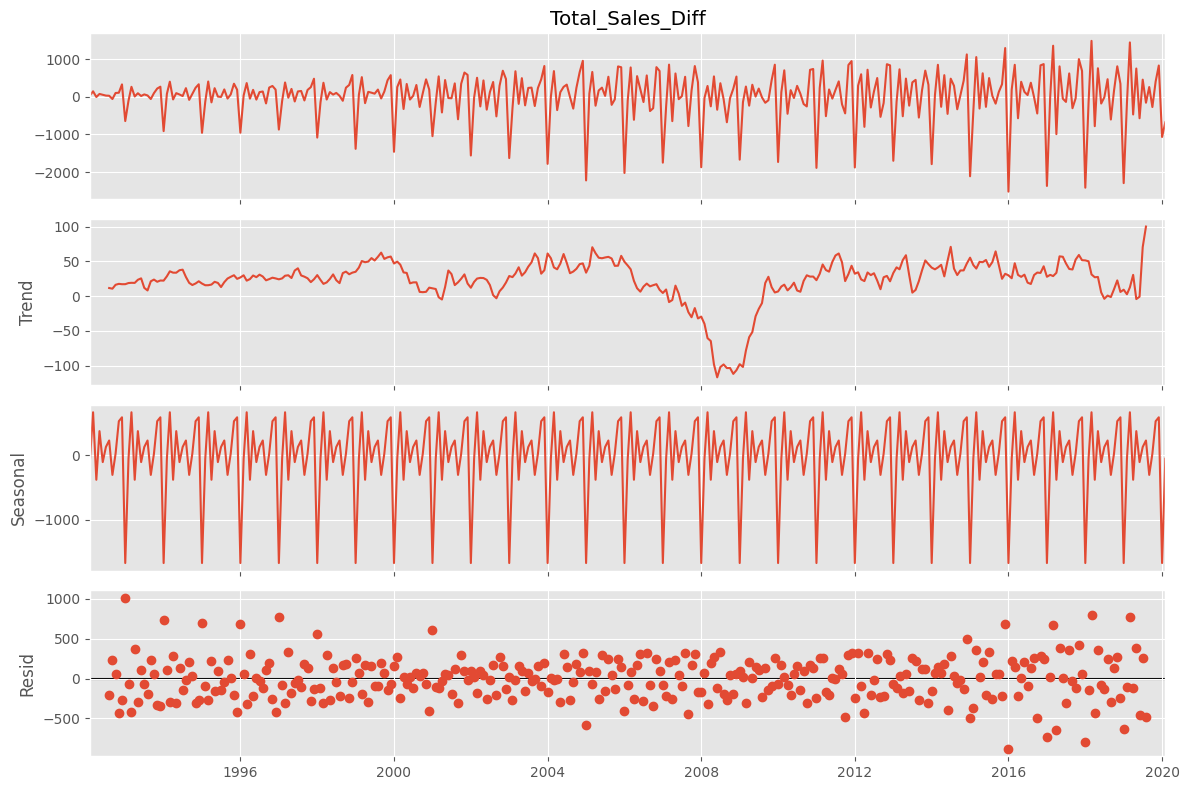

In [17]:
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df1["Total_Sales_Diff"], model = "add")
a.plot();

In [18]:
# Splitting train and test data
train_data = df[:len(df)-12]
test_data = df[len(df)-12:]
test=test_data.copy()

In [19]:
train_data.shape, test_data.shape

((326, 1), (12, 1))

In [20]:
test_data

,Total_Sales_Adjusted
Month,
2019-03-01,9718.107698
2019-04-01,9248.814254
2019-05-01,10001.305300
2019-06-01,9431.337229
2019-07-01,9887.800688
2019-08-01,9730.231000
2019-09-01,9991.001000
2019-10-01,9720.121000
2019-11-01,10127.300000


In [21]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.2 MB/s eta 0:00:00


In [22]:
# Auto-ARIMA Model
from pmdarima import auto_arima

In [23]:
model_auto=auto_arima(train_data,start_p=0,d=1,start_q=0,
          max_p=4,max_d=2,max_q=4, start_P=0,
          D=1, start_Q=0, max_P=2,max_D=1,
          max_Q=2, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)
print(model_auto)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4265.008, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4202.966, Time=0.44 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4174.756, Time=0.70 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=4192.148, Time=0.17 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=4158.596, Time=1.49 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=4184.482, Time=0.73 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=4154.119, Time=5.88 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=4173.286, Time=1.48 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=6.10 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=4156.758, Time=4.60 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=4215.049, Time=2.55 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=4155.871, Time=3.66 sec
 ARIMA(0,1,2)(2,1,1)[12]             : AIC=4155.689, Time=3.02 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=4170.853, Time=3.58 sec
 ARIMA(1,1,2)(2,1,1)[12]

In [24]:
print(model_auto.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  326
Model:             SARIMAX(2, 1, 3)x(2, 1, [], 12)   Log Likelihood               -2053.392
Date:                             Thu, 18 Apr 2024   AIC                           4122.784
Time:                                     20:31:08   BIC                           4152.754
Sample:                                 01-01-1992   HQIC                          4134.761
                                      - 02-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1532      0.010   -112.593      0.000      -1.173      -1.133
ar.L2         -0.9958      

In [25]:
# Implementing the model with the selected best fit
arima_model = SARIMAX(train_data["Total_Sales_Adjusted"], order = (0,1,1), seasonal_order = (2,1,2,12))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                    Total_Sales_Adjusted   No. Observations:                  326
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood               -2062.656
Date:                                 Thu, 18 Apr 2024   AIC                           4137.312
Time:                                         20:31:18   BIC                           4159.789
Sample:                                     01-01-1992   HQIC                          4146.294
                                          - 02-01-2019                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3800      0.044     -8.652      0.000      -0.466      -0.294
ar.S.L12       0.9576      0.059     16.192      0.000       0.842       1.073
ar.S.L24      -0.9092      0.056    -16.312      0.000      -1.018      -0.800
ma.S.L12      -1.2025      0.254     -4.733      0.000      -1.700      -0.705
ma.S.L24       0.9751      0.396      2.461      0.014       0.199       1.752
sigma2      2.758e+04   9619.082      2.867      0.004    8727.100    4.64e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                17.69
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               3.57   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

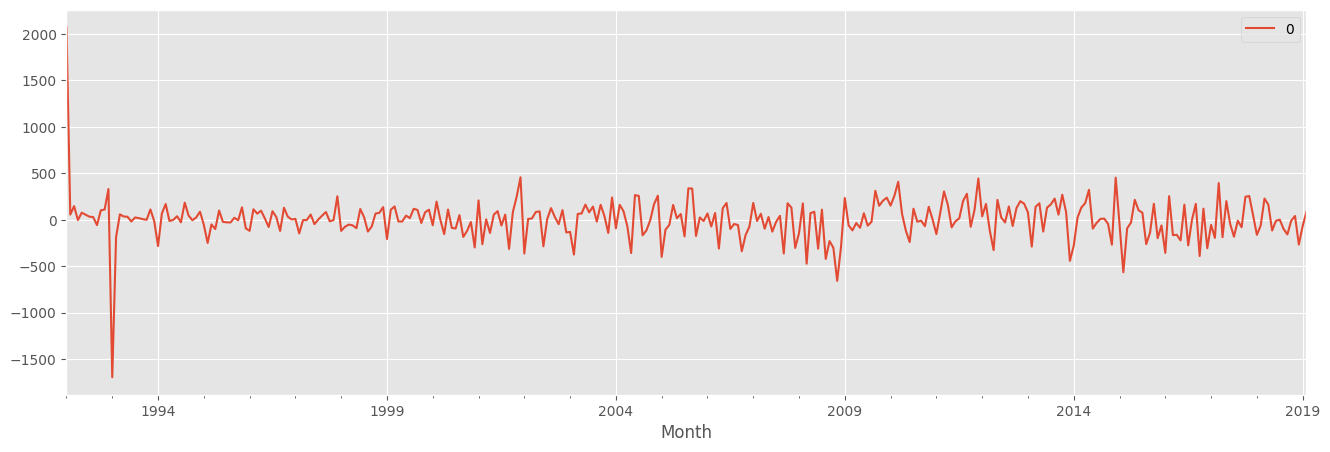

In [26]:
# Residuals Errors Curve
residuals = pd.DataFrame(arima_result.resid)
residuals.plot(figsize = (16,5));
plt.show();

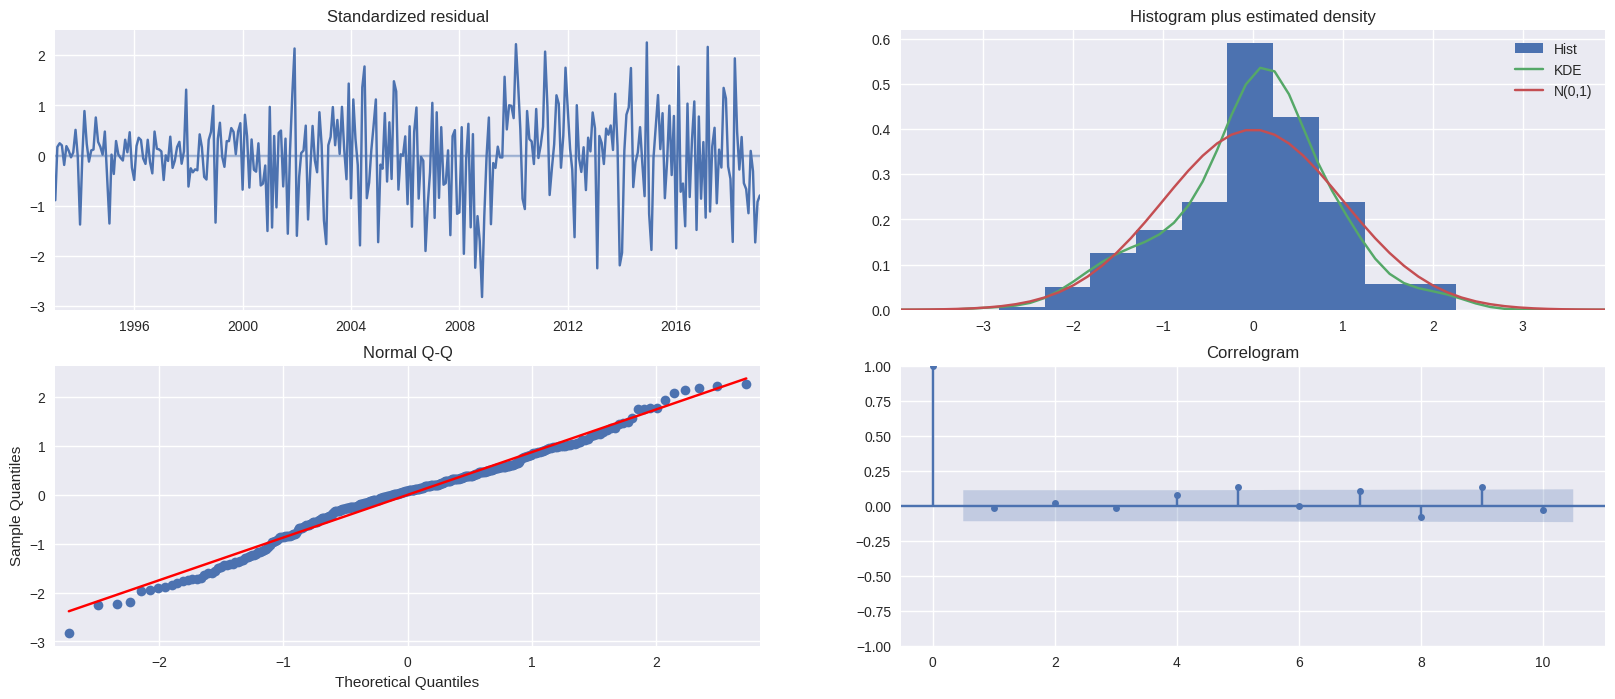

In [27]:
plt.style.use('seaborn')
model_auto.plot_diagnostics(figsize=(20,8))
plt.show()

In [28]:
# Left Upper: Residual errors fluctuate over a media 0 with uniform variance
# Right Upper: Density data graphic shows a normal distribution with media 0.
# Left Bottom: Almost perfect alignment with minimal desviation
# Rigth Bottom: Correlogram, also known as ACF graph, shows that residual errors are not self-corelated.
# If so, it would imply a pattern not able to be explain by this model

In [29]:
# Predictions based on train data
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2019-03-01     9530.456093
2019-04-01     8931.569981
2019-05-01     9733.264681
2019-06-01     9442.491944
2019-07-01     9552.292360
2019-08-01     9821.424421
2019-09-01     9263.000317
2019-10-01     9453.340244
2019-11-01    10026.590738
2019-12-01    10500.035788
2020-01-01     8155.704347
2020-02-01     7986.190644
Freq: MS, Name: ARIMA Predictions, dtype: float64

In [30]:
# Additionally, it can predict based on dates
arima_pred2 = arima_result.predict(start='2015-01-01',end='2025-01-01', typ="levels").rename("ARIMA Predictions")
arima_pred2

2015-01-01     7313.240822
2015-02-01     7450.785982
2015-03-01     8034.694257
2015-04-01     7661.007260
2015-05-01     8041.426258
                  ...     
2024-09-01     9389.634436
2024-10-01     9521.797037
2024-11-01    10330.407074
2024-12-01    10721.872134
2025-01-01     8393.123979
Freq: MS, Name: ARIMA Predictions, Length: 121, dtype: float64

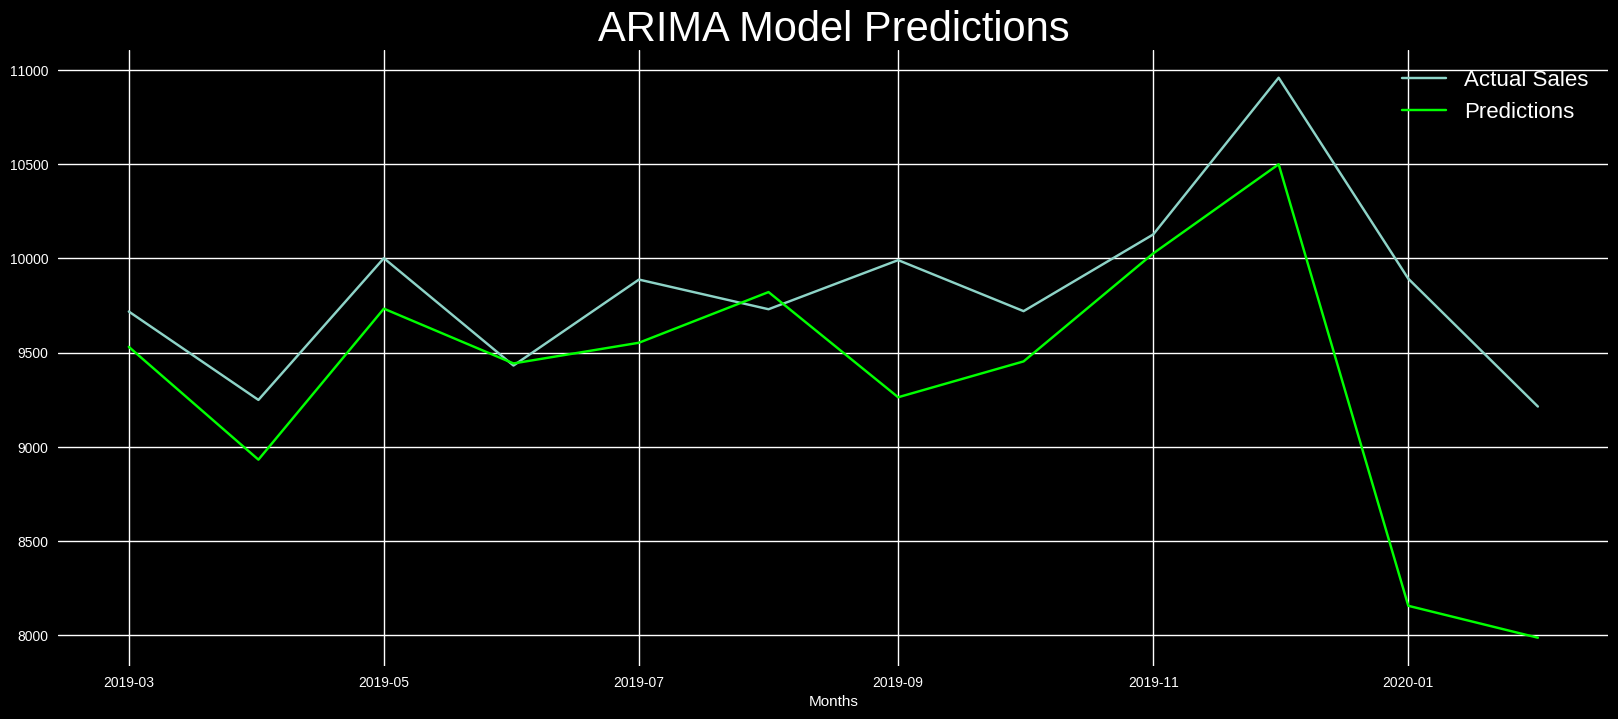

In [31]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(test_data["Total_Sales_Adjusted"], label="Actual Sales")
plt.plot(arima_pred, color="lime", label="Predictions")
plt.title("ARIMA Model Predictions", fontsize=30);
plt.xlabel('Months')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

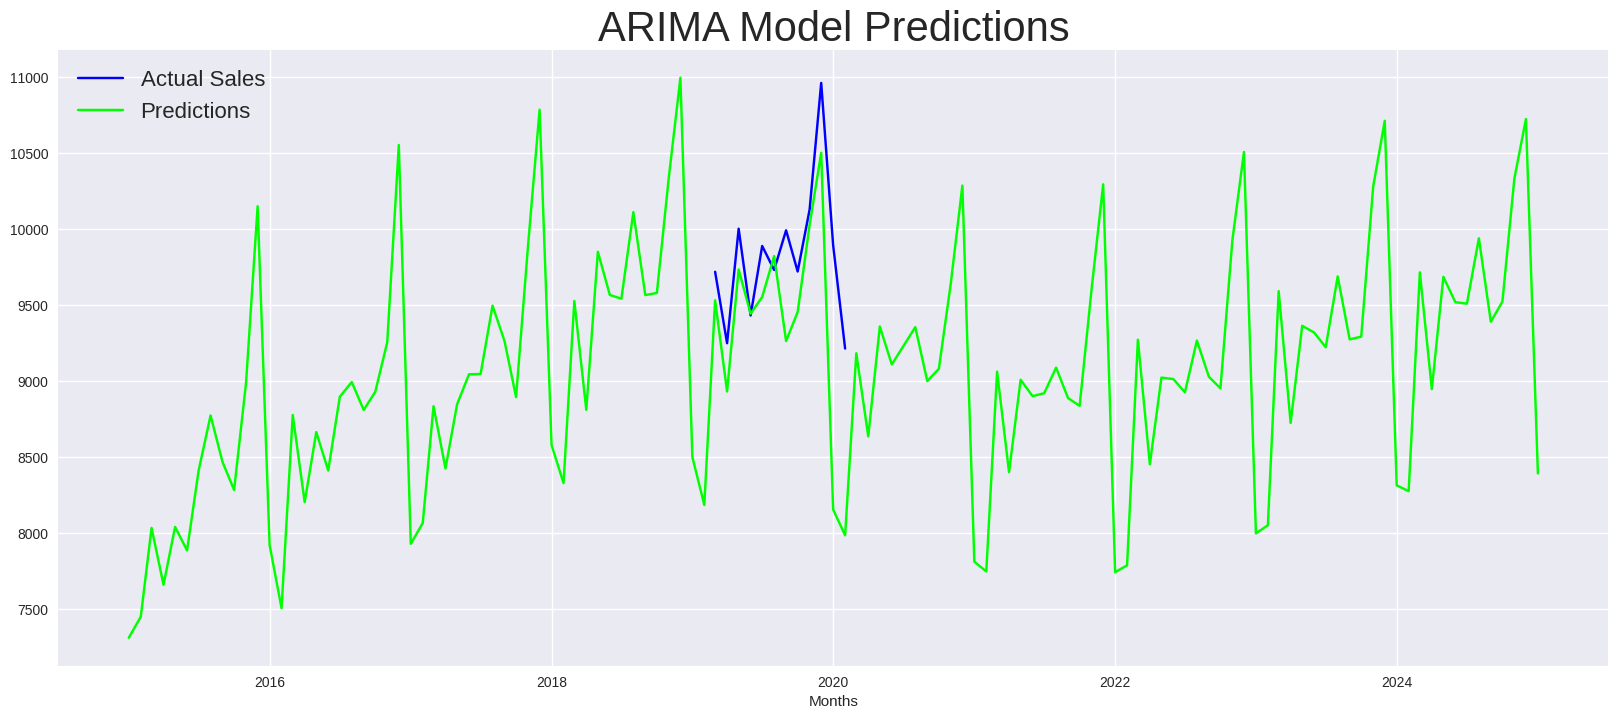

In [32]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(test_data["Total_Sales_Adjusted"],color="blue" ,label="Actual Sales")
plt.plot(arima_pred2, color="lime", label="Predictions")
plt.title("ARIMA Model Predictions", fontsize=30);
plt.xlabel('Months')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

In [33]:
# Data will be saved for comparison
evaluation_metric(test_data,arima_pred)

Evaluation metric results:-
MSE is : 472854.3284583975
MAE is : 477.49723374431807
RMSE is : 687.6440419711331
MAPE is : 7.080095692863389
R2 is : -1.4273785846538254



In [34]:
test_data['ARIMA_Predictions'] = arima_pred

In [35]:
# LSTM Forecast based on NN
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [36]:
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)

scaled_test_data = scaler.transform(test)

In [37]:
# Time Series Generator object creation for LSTM Model
from keras.preprocessing.sequence import TimeseriesGenerator

In [38]:
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [39]:
# Number of iterations: 200
# Activation: relu - rectified lineal unit $f(x) = max(0,x)$
# Weight optimizer: adam - stochastic gradient
# Loss: MSE
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 161801 (632.04 KB)
Trainable params: 161801 (632.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
lstm_model.fit_generator(generator,epochs=100)

Epoch 1/100
314/314 [==============================] - 7s 17ms/step - loss: 0.0121
Epoch 2/100
314/314 [==============================] - 4s 12ms/step - loss: 0.0060
Epoch 3/100
314/314 [==============================] - 5s 17ms/step - loss: 0.0045
Epoch 4/100
314/314 [==============================] - 4s 11ms/step - loss: 0.0054
Epoch 5/100
314/314 [==============================] - 4s 13ms/step - loss: 0.0045
Epoch 6/100
314/314 [==============================] - 4s 13ms/step - loss: 0.0056
Epoch 7/100
314/314 [==============================] - 4s 12ms/step - loss: 0.0041
Epoch 8/100
314/314 [==============================] - 4s 13ms/step - loss: 0.0037
Epoch 9/100
314/314 [==============================] - 4s 13ms/step - loss: 0.0034
Epoch 10/100
314/314 [==============================] - 4s 12ms/step - loss: 0.0028
Epoch 11/100
314/314 [==============================] - 5s 17ms/step - loss: 0.0034
Epoch 12/100
314/314 [==============================] - 4s 12ms/step - loss: 0.0030
E

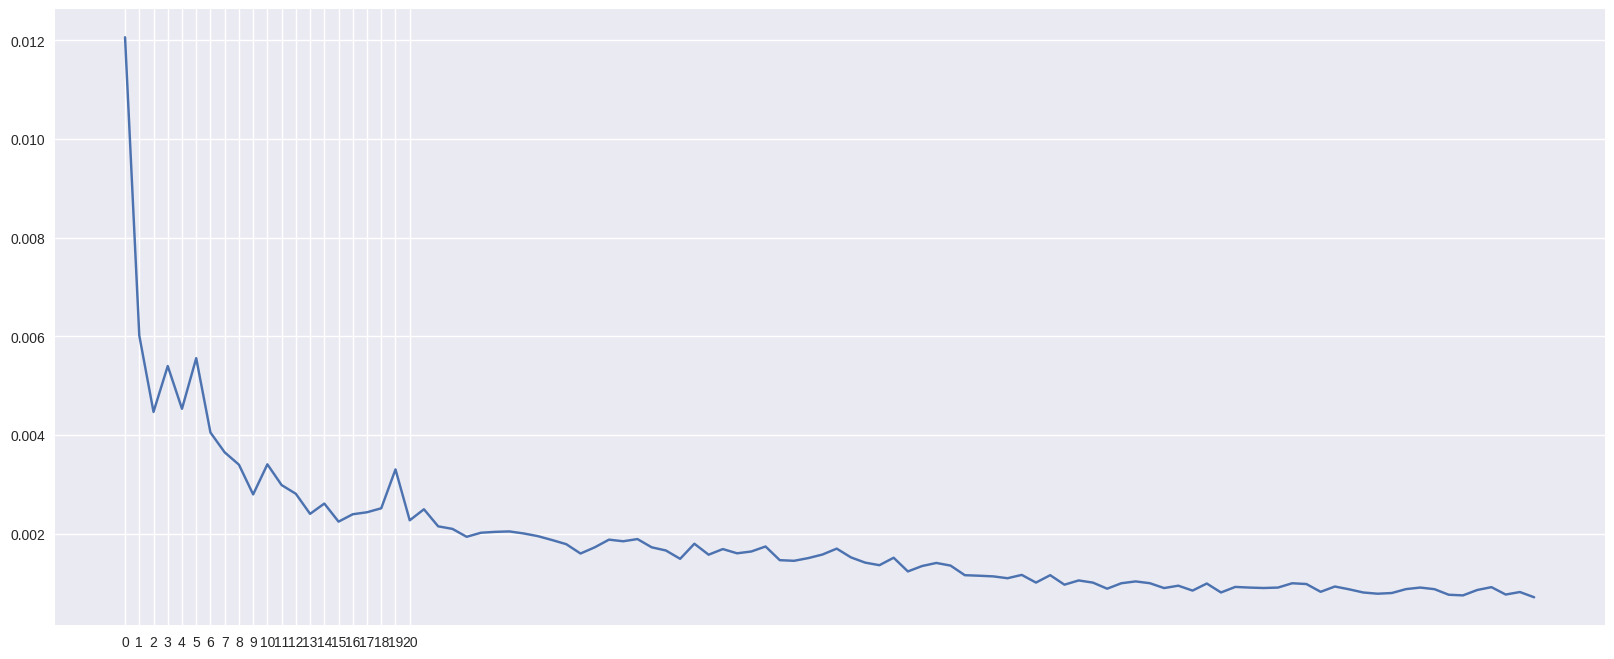

In [41]:
losses_lstm = lstm_model.history.history['loss']
#plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [42]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 [==============================] - 0s 27ms/step


In [43]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [44]:
lstm_predictions

array([[10095.59470669],
       [ 9277.43608755],
       [ 9983.63048671],
       [ 9967.33186138],
       [ 9607.41445855],
       [10491.21192087],
       [ 9708.91602101],
       [ 9719.99584897],
       [10654.4331376 ],
       [10764.615291  ],
       [ 8871.06172843],
       [ 8719.45396757]])

In [45]:
test_data['LSTM_Predictions'] = lstm_predictions

In [46]:
test_data

,Total_Sales_Adjusted,ARIMA_Predictions,LSTM_Predictions
Month,,,
2019-03-01,9718.107698,9530.456093,10095.594707
2019-04-01,9248.814254,8931.569981,9277.436088
2019-05-01,10001.305300,9733.264681,9983.630487
2019-06-01,9431.337229,9442.491944,9967.331861
2019-07-01,9887.800688,9552.292360,9607.414459
2019-08-01,9730.231000,9821.424421,10491.211921
2019-09-01,9991.001000,9263.000317,9708.916021
2019-10-01,9720.121000,9453.340244,9719.995849
2019-11-01,10127.300000,10026.590738,10654.433138


In [47]:
ai=test_data[["Total_Sales_Adjusted","LSTM_Predictions"]]
fig = px.line(ai, x=test_data.index, y=ai.columns,title="LSTM Model Predictions", template = "plotly_dark")
fig.show()

In [48]:
evaluation_metric(test_data["Total_Sales_Adjusted"],test_data["LSTM_Predictions"])

Evaluation metric results:-
MSE is : 230970.11548939277
MAE is : 376.747636736364
RMSE is : 480.5935033782633
MAPE is : 3.850575051733233
R2 is : -0.18567575316866303



In [49]:
df5 = pd.read_csv("/content/drive/MyDrive/ds_totalsales.csv")
df5.head()

,Month,Total_Sales_Adjusted
0,1/1/1992,2073.432724
1,2/1/1992,2114.485812
2,3/1/1992,2260.570891
3,4/1/1992,2255.103236
4,5/1/1992,2331.414618


In [50]:
df5['Total_Sales_pct_Change']= df5['Total_Sales_Adjusted'].pct_change()
df5.dropna(inplace=True)
df5.head()

,Month,Total_Sales_Adjusted,Total_Sales_pct_Change
1,2/1/1992,2114.485812,0.019800
2,3/1/1992,2260.570891,0.069088
3,4/1/1992,2255.103236,-0.002419
4,5/1/1992,2331.414618,0.033839
5,6/1/1992,2384.638567,0.022829


In [51]:
df5['Total_Sales_pct_Change'].describe()

count    337.000000
mean       0.009216
std        0.094211
min       -0.284492
25%       -0.032032
50%        0.022893
75%        0.073659
max        0.179970
Name: Total_Sales_pct_Change, dtype: float64

In [52]:
fig = px.line(df5, x="Month", y="Total_Sales_pct_Change",template = "plotly_dark",
              title="Change Percentage")
fig.show()

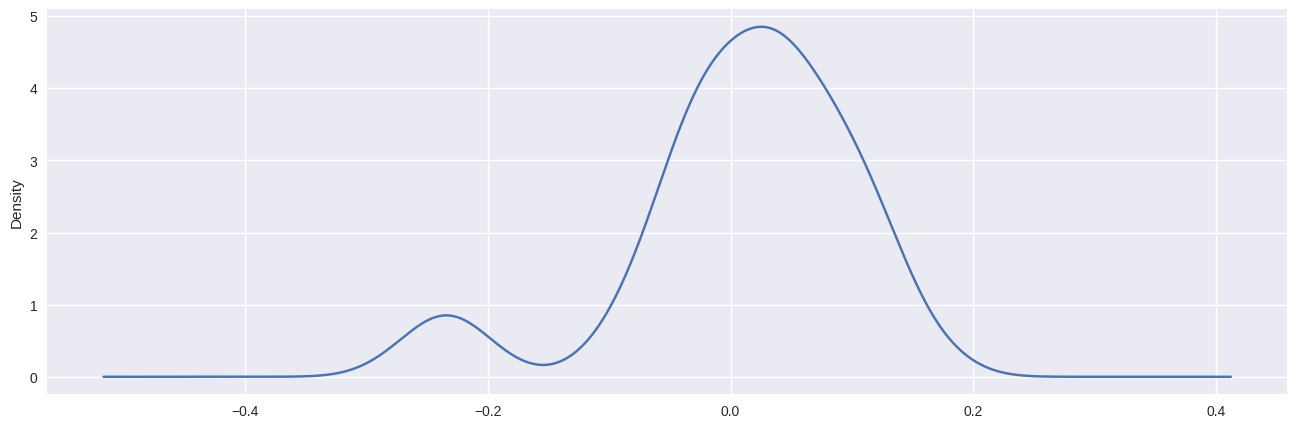

In [53]:
df5['Total_Sales_pct_Change'].plot(kind='kde',figsize = (16,5));

In [54]:
# Seasonal Variables
df5['Month'] = pd.to_datetime(df5['Month'])
df5['Year'] = df5['Month'].apply(lambda x: x.year)
df5['MM'] = df5['Month'].apply(lambda x: x.month)
df5.head()

,Month,Total_Sales_Adjusted,Total_Sales_pct_Change,Year,MM
1,1992-02-01,2114.485812,0.019800,1992,2
2,1992-03-01,2260.570891,0.069088,1992,3
3,1992-04-01,2255.103236,-0.002419,1992,4
4,1992-05-01,2331.414618,0.033839,1992,5
5,1992-06-01,2384.638567,0.022829,1992,6


In [55]:
# Adding an Entire Data Year
df5['L1'] = df5["Total_Sales_pct_Change"].shift(1)
df5['L2'] = df5["Total_Sales_pct_Change"].shift(2)
df5['L3'] = df5["Total_Sales_pct_Change"].shift(3)
df5['L4'] = df5["Total_Sales_pct_Change"].shift(4)
df5['L5'] = df5["Total_Sales_pct_Change"].shift(5)
df5['L6'] = df5["Total_Sales_pct_Change"].shift(6)
df5['L7'] = df5["Total_Sales_pct_Change"].shift(7)
df5['L8'] = df5["Total_Sales_pct_Change"].shift(8)
df5['L9'] = df5["Total_Sales_pct_Change"].shift(9)
df5['L10'] = df5["Total_Sales_pct_Change"].shift(10)
df5['L11'] = df5["Total_Sales_pct_Change"].shift(11)
df5['L12'] = df5["Total_Sales_pct_Change"].shift(12)

In [56]:
df5.head(13)

,Month,Total_Sales_Adjusted,Total_Sales_pct_Change,Year,MM,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12
1,1992-02-01,2114.485812,0.019800,1992,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1992-03-01,2260.570891,0.069088,1992,3,0.019800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1992-04-01,2255.103236,-0.002419,1992,4,0.069088,0.019800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1992-05-01,2331.414618,0.033839,1992,5,-0.002419,0.069088,0.019800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1992-06-01,2384.638567,0.022829,1992,6,0.033839,-0.002419,0.069088,0.019800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1992-07-01,2417.165376,0.013640,1992,7,0.022829,0.033839,-0.002419,0.069088,0.019800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1992-08-01,2445.498729,0.011722,1992,8,0.013640,0.022829,0.033839,-0.002419,0.069088,0.019800,NaN,NaN,NaN,NaN,NaN,NaN
8,1992-09-01,2387.351705,-0.023777,1992,9,0.011722,0.013640,0.022829,0.033839,-0.002419,0.069088,0.019800,NaN,NaN,NaN,NaN,NaN
9,1992-10-01,2489.350838,0.042725,1992,10,-0.023777,0.011722,0.013640,0.022829,0.033839,-0.002419,0.069088,0.019800,NaN,NaN,NaN,NaN
10,1992-11-01,2598.186297,0.043720,1992,11,0.042725,-0.023777,0.011722,0.013640,0.022829,0.033839,-0.002419,0.069088,0.019800,NaN,NaN,NaN


In [57]:
df5 = df5.dropna()
df5.head()

,Month,Total_Sales_Adjusted,Total_Sales_pct_Change,Year,MM,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12
13,1993-02-01,2183.137948,-0.044419,1993,2,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829,0.033839,-0.002419,0.069088,0.019800
14,1993-03-01,2449.195623,0.121869,1993,3,-0.044419,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829,0.033839,-0.002419,0.069088
15,1993-04-01,2457.704334,0.003474,1993,4,0.121869,-0.044419,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829,0.033839,-0.002419
16,1993-05-01,2552.874950,0.038723,1993,5,0.003474,0.121869,-0.044419,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829,0.033839
17,1993-06-01,2575.018055,0.008674,1993,6,0.038723,0.003474,0.121869,-0.044419,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829


In [58]:
df5= df5.set_index("Month")
df5.head()

,Total_Sales_Adjusted,Total_Sales_pct_Change,Year,MM,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12
Month,,,,,,,,,,,,,,,,
1993-02-01,2183.137948,-0.044419,1993,2,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829,0.033839,-0.002419,0.069088,0.019800
1993-03-01,2449.195623,0.121869,1993,3,-0.044419,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829,0.033839,-0.002419,0.069088
1993-04-01,2457.704334,0.003474,1993,4,0.121869,-0.044419,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829,0.033839,-0.002419
1993-05-01,2552.874950,0.038723,1993,5,0.003474,0.121869,-0.044419,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829,0.033839
1993-06-01,2575.018055,0.008674,1993,6,0.038723,0.003474,0.121869,-0.044419,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829


In [59]:
# Split into late variables (characteristics) and original time series (objetive)
X2= df5.iloc[:,2:] # split all columns starting by 0 thru the end without including it
y2 = df5.iloc[:,1] # split all columns including the last one, basically column 't'

In [60]:
X2.head(3)

,Year,MM,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12
Month,,,,,,,,,,,,,,
1993-02-01,1993,2,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829,0.033839,-0.002419,0.069088,0.019800
1993-03-01,1993,3,-0.044419,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829,0.033839,-0.002419,0.069088
1993-04-01,1993,4,0.121869,-0.044419,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829,0.033839,-0.002419


In [61]:
y2.head()

Month
1993-02-01   -0.044419
1993-03-01    0.121869
1993-04-01    0.003474
1993-05-01    0.038723
1993-06-01    0.008674
Name: Total_Sales_pct_Change, dtype: float64

In [62]:
# Target Train-Test split
from pandas import read_csv

Y2 = y2
traintarget_size = int(len(Y2) * 0.80)   # Set split
train_target, test_target = Y2[0:traintarget_size], Y2[traintarget_size:len(Y2)]

print('Number of Observations to Achieve the Objective: %d' % (len(Y2)))
print('Number of Observations to Train the Objective: %d' % (len(train_target)))
print('Number of Observations to Test the Objective: %d' % (len(test_target)))

Number of Observations to Achieve the Objective: 325
Number of Observations to Train the Objective: 260
Number of Observations to Test the Objective: 65


In [63]:
# Features Train-Test split

trainfeature_size = int(len(X2) * 0.80)
train_feature, test_feature = X2[0:trainfeature_size], X2[trainfeature_size:len(X2)]
print('Number of Observations to Achieve the Characteristics: %d' % (len(X2)))
print('Number of Observations to Train the Characteristics: %d' % (len(train_feature)))
print('Number of Observations to Test the Characteristics: %d' % (len(test_feature)))

Number of Observations to Achieve the Characteristics: 325
Number of Observations to Train the Characteristics: 260
Number of Observations to Test the Characteristics: 65


In [64]:
# Creatimg Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2,  shuffle=False)

In [65]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

# Creating a Model with 500 decision trees
rfr = RandomForestRegressor(n_estimators=500)

# Training the Model
rfr.fit(train_feature, train_target)

# Making the Predictions
fcst = rfr.predict(test_feature)

In [66]:
b=pd.DataFrame({"Actual":test_target, "Random Forest":fcst})
b

,Actual,Random Forest
Month,,
2014-10-01,0.005829,0.029116
2014-11-01,0.054576,0.076693
2014-12-01,0.136647,0.071270
2015-01-01,-0.225245,-0.235124
2015-02-01,-0.052407,-0.004274
...,...,...
2019-10-01,-0.027112,0.028334
2019-11-01,0.041890,0.078512
2019-12-01,0.082169,0.068857


In [67]:
#b.set_index("2018-08-01")
#b=b.loc['2018-08-01':"2019-07-01"]

In [68]:
fig = px.line(b, x=b.index, y=b.columns,template = "plotly_dark",
              title="Random Forest Model Prediction")
fig.show()

In [69]:
evaluation_metric(test_target,fcst)

Evaluation metric results:-
MSE is : 0.0013035258597280275
MAE is : 0.026341692884624134
RMSE is : 0.03610437452342898
MAPE is : 234.84563289893777
R2 is : 0.8566909229297813



In [70]:
import pandas as pd
from prophet import Prophet

In [71]:
df6 = df.copy()
df6.head()

,Total_Sales_Adjusted
Month,
1992-01-01,2073.432724
1992-02-01,2114.485812
1992-03-01,2260.570891
1992-04-01,2255.103236
1992-05-01,2331.414618


In [72]:
df6=df6.reset_index()

In [73]:
df_fb=df6.rename(columns={"Month":"ds", "Total_Sales_Adjusted":"y"} )
df_fb.head()

,ds,y
0,1992-01-01,2073.432724
1,1992-02-01,2114.485812
2,1992-03-01,2260.570891
3,1992-04-01,2255.103236
4,1992-05-01,2331.414618


In [74]:
train_data_pr = df_fb.iloc[:len(df6)-12]
test_data_pr = df_fb.iloc[len(df6)-12:]

In [75]:
from prophet import Prophet

In [76]:
m = Prophet()

# Let us train the model
m.fit(train_data_pr)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiipew3ny/1s3ngyrs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiipew3ny/jjxt3_lu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21623', 'data', 'file=/tmp/tmpiipew3ny/1s3ngyrs.json', 'init=/tmp/tmpiipew3ny/jjxt3_lu.json', 'output', 'file=/tmp/tmpiipew3ny/prophet_model5yu5cg87/prophet_model-20240418204144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:41:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:41:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [77]:
future = m.make_future_dataframe(periods=12,freq='MS')
prophet_pred = m.predict(future)

In [78]:
prophet_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1992-01-01,2249.414157,1336.112865,1885.253118,2249.414157,2249.414157,-635.313859,-635.313859,-635.313859,-635.313859,-635.313859,-635.313859,0.0,0.0,0.0,1614.100298
1,1992-02-01,2272.623103,1380.257912,1957.794576,2272.623103,2272.623103,-603.964341,-603.964341,-603.964341,-603.964341,-603.964341,-603.964341,0.0,0.0,0.0,1668.658762
2,1992-03-01,2294.334698,2055.466017,2631.086711,2294.334698,2294.334698,34.963431,34.963431,34.963431,34.963431,34.963431,34.963431,0.0,0.0,0.0,2329.298128
3,1992-04-01,2317.543644,1647.606267,2248.554092,2317.543644,2317.543644,-359.461229,-359.461229,-359.461229,-359.461229,-359.461229,-359.461229,0.0,0.0,0.0,1958.082415
4,1992-05-01,2340.003914,2014.088400,2594.329806,2340.003914,2340.003914,-53.325515,-53.325515,-53.325515,-53.325515,-53.325515,-53.325515,0.0,0.0,0.0,2286.678399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,2019-10-01,10088.814267,9724.132059,10313.759503,10060.697077,10111.137162,-75.192056,-75.192056,-75.192056,-75.192056,-75.192056,-75.192056,0.0,0.0,0.0,10013.622211
334,2019-11-01,10126.952483,10274.972571,10892.243187,10090.564999,10155.177461,451.918744,451.918744,451.918744,451.918744,451.918744,451.918744,0.0,0.0,0.0,10578.871227
335,2019-12-01,10163.860435,10969.496049,11546.537184,10115.692962,10202.807764,1101.581538,1101.581538,1101.581538,1101.581538,1101.581538,1101.581538,0.0,0.0,0.0,11265.441973
336,2020-01-01,10201.998651,9269.322325,9864.260010,10144.007485,10250.508081,-635.313859,-635.313859,-635.313859,-635.313859,-635.313859,-635.313859,0.0,0.0,0.0,9566.684792


In [79]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-12:]['ds'], "Pred" : prophet_pred[-12:]["yhat"]})

In [80]:
prophet_pred = prophet_pred.set_index("Date")

In [81]:
prophet_pred.index.freq = "MS"

In [82]:
prophet_pred

,Pred
Date,
2019-03-01,9771.541544
2019-04-01,9474.436529
2019-05-01,9895.842383
2019-06-01,9820.206879
2019-07-01,9964.043622
2019-08-01,10257.147050
2019-09-01,9968.980292
2019-10-01,10013.622211
2019-11-01,10578.871227


In [83]:
test_data["Prophet_Predictions"] = prophet_pred['Pred'].values

In [84]:
test_data.head()

,Total_Sales_Adjusted,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions
Month,,,,
2019-03-01,9718.107698,9530.456093,10095.594707,9771.541544
2019-04-01,9248.814254,8931.569981,9277.436088,9474.436529
2019-05-01,10001.305300,9733.264681,9983.630487,9895.842383
2019-06-01,9431.337229,9442.491944,9967.331861,9820.206879
2019-07-01,9887.800688,9552.292360,9607.414459,9964.043622


In [85]:
a=test_data[["Total_Sales_Adjusted","Prophet_Predictions"]]
fig = px.line(a, x=test_data.index, y=a.columns,template = "plotly_dark",
              title="Prophet Model Prediction")
fig.show()

In [86]:
fig = px.line(test_data, x=test_data.index, y=test_data.columns,template = "plotly_dark",
              title="Predicciones")
fig.show()

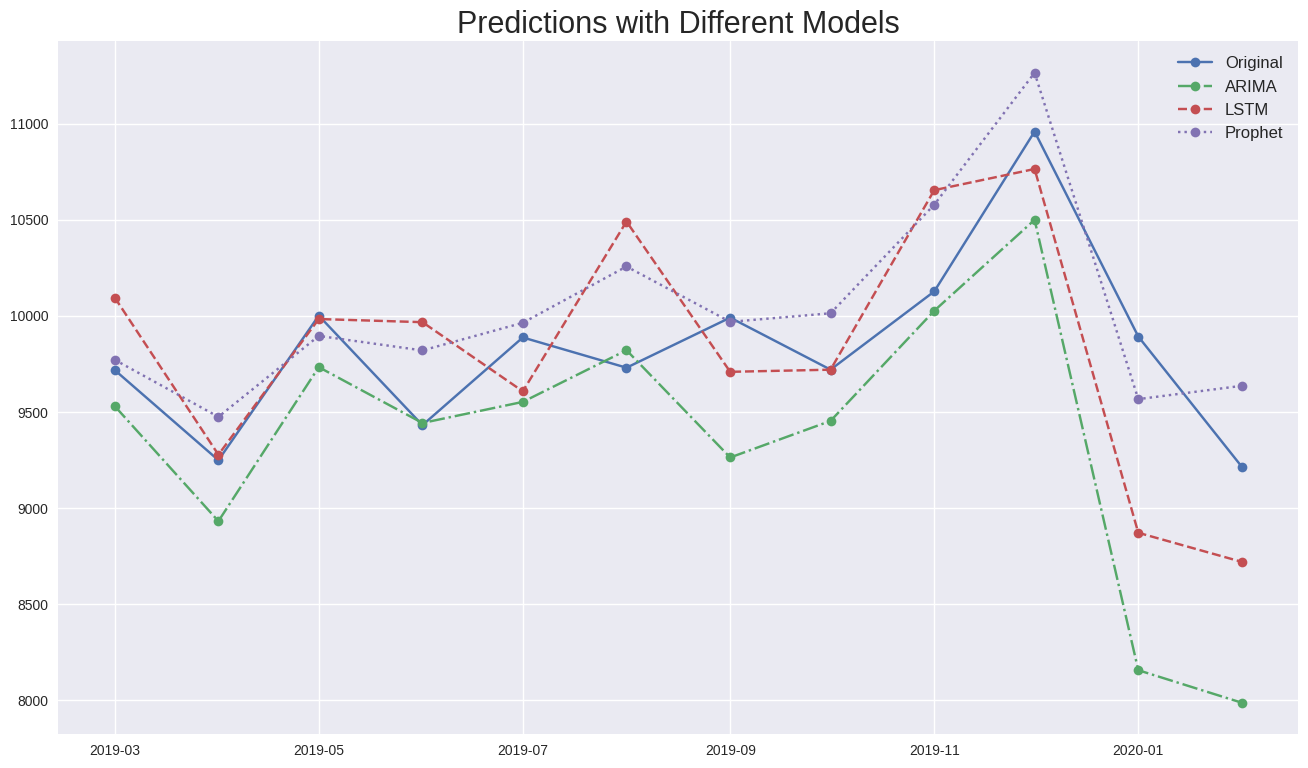

In [87]:
plt.figure(figsize=(16,9))
plt.plot_date(test_data.index, test_data["Total_Sales_Adjusted"],label="Original", linestyle="-")
plt.plot_date(test_data.index, test_data["ARIMA_Predictions"], label="ARIMA",linestyle="-.")
plt.plot_date(test_data.index, test_data["LSTM_Predictions"],label="LSTM", linestyle="--")
plt.plot_date(test_data.index, test_data["Prophet_Predictions"], label="Prophet",linestyle=":")
plt.legend(fontsize=12)
plt.title("Predictions with Different Models", fontsize=22)
plt.show();

In [88]:
test_data

,Total_Sales_Adjusted,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions
Month,,,,
2019-03-01,9718.107698,9530.456093,10095.594707,9771.541544
2019-04-01,9248.814254,8931.569981,9277.436088,9474.436529
2019-05-01,10001.305300,9733.264681,9983.630487,9895.842383
2019-06-01,9431.337229,9442.491944,9967.331861,9820.206879
2019-07-01,9887.800688,9552.292360,9607.414459,9964.043622
2019-08-01,9730.231000,9821.424421,10491.211921,10257.147050
2019-09-01,9991.001000,9263.000317,9708.916021,9968.980292
2019-10-01,9720.121000,9453.340244,9719.995849,10013.622211
2019-11-01,10127.300000,10026.590738,10654.433138,10578.871227
